In [160]:
import numpy as np
import random 
import time

# 0. Preliminaries 

In [342]:
def sigmoid(x):
    return 1/(np.exp(-np.array(x))+1)

def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def convert_pred(y):
    """
    given an array y, returns an array with the same shape and all zeros except
    a single 1 at the index where y attains its maximum value
    """
    new_y = np.zeros(y.shape)
    max_ind = np.where(y==max(y))
    new_y[max_ind] = 1
    return new_y

In [343]:
sigmoid([-5,0,5])

array([0.00669285, 0.5       , 0.99330715])

In [344]:
dsigmoid([-5,0,5])

array([0.00664806, 0.25      , 0.00664806])

In [346]:
v = np.random.randn(5, 1)
print(v)
convert_pred(v)

[[-0.89638585]
 [-0.48789934]
 [-1.41876809]
 [-0.20277104]
 [ 0.32719624]]


array([[0.],
       [0.],
       [0.],
       [0.],
       [1.]])

# 1. Building a Simple Neural Network

In [1]:
class ANN(object):

    def __init__(self,layers):
        """
        layers should be a list of the number of nodes in each layer.
        For example, if layers = [10,20,3] the network will have an input layer
        with 10 nodes, a hidden layer with 20 nodes, and an output layer with 3 nodes

        by default the activation function is the sigmoid and the cost function
        is squared-error

        We randomly generate our initial biases and weights using a standard
        normal distribution.
        """
        self.num_layers = len(layers)
        self.layers = layers

        self.bias = [np.random.randn(y, 1) for y in layers[1:]]
        """
        self.weights is an array of matrices; self.weights[i] is
        the weight matrix between layers i+1 and i+2, where the k-th column
        contains the weights corresponding to the k-th neuron in layer i+1
        """
        self.weights = [np.random.randn(y,x) for x,y in zip(layers[:-1], layers[1:])]

    def reset_weights(self):
        self.bias = [np.random.randn(y, 1) for y in self.layers[1:]]
        self.weights = [np.random.randn(y,x) for x,y in zip(self.layers[:-1], self.layers[1:])]

    def evaluate(self,a):
        """
        returns the output of the network for given input array "a"
        """
        for b,w in zip(self.bias, self.weights):
            a = sigmoid(np.dot(w,a)+b)
        return a

    def backprop(self,x,y):
        """"
        performs backpropogation based on a point, x, and the
        corresponding desired output, y;

        explicitly, we compute the "error derivatives" for the weights and biases,
        which we return as a tuple (grad_b,grad_w);
        
        these will then be averaged and scaled in the train loop, and the network's
        weights/bias will be adjusted accordingly
        """
        grad_b = [np.zeros(b.shape) for b in self.bias]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        a_l = np.array(x)
        a = [a_l]
        zs = []
        Ds = []
        for b,w in zip(self.bias, self.weights):
            z_l = np.dot(w,a_l)+b
            zs.append(z_l)
            a_l = sigmoid(z_l)
            a.append(a_l)
            d_l = np.diag(dsigmoid(z_l).squeeze())
            Ds.append(d_l)
        delta_l = np.dot(Ds[-1],(a[-1]-y))
        grad_b[-1] = delta_l
        grad_w[-1] = np.dot(delta_l, a[-2].transpose())
        for k in range(2,self.num_layers):
            delta_l = np.dot(np.dot(Ds[-k],self.weights[-k+1].transpose()), delta_l)
            grad_b[-k] = delta_l
            grad_w[-k] = np.dot(delta_l, a[-k-1].transpose())
        return (grad_b,grad_w)
        
    def train(self,X,Y,m,eta,N):
        """
        Performs SGD to train the network

        X = training data, stored as n1 x n2 array, where each column is a data
            point in R^n1 and we have n2 many points
        Y = desired output matrix; for classification should be
            num_classes x n2
        m = sample size at each step of SGD
        eta = step size
        N = max number of iterations/ steps
        """
        start = time.time()
        num_col = X.shape[1]
        count = 0
        while count <= N:
            sample = random.choices(range(num_col),k=m)
            xs = X[:,sample]
            ys = Y[:,sample]
            delta_b = [np.zeros(b.shape) for b in self.bias]
            delta_w = [np.zeros(w.shape) for w in self.weights]
            for i in range(m):
                x = np.array([xs[:,i]]).transpose()
                y = np.array([ys[:,i]]).transpose()
                delta_bi, delta_wi = self.backprop(x,y)
                delta_b = [db+dbi for db, dbi in zip(delta_b, delta_bi)]
                delta_w = [dw+dwi for dw, dwi in zip(delta_w, delta_wi)]
            self.weights = [w-(eta/m)*dw
                        for w, dw in zip(self.weights, delta_w)]
            self.bias = [b-(eta/m)*db
                        for b, db in zip(self.bias, delta_b)]
            count += 1
        end = time.time()
        print('Training Complete!')
        print('Training took:',end-start, 'seconds')
        
    def test(self,X,Y):
        num_col = X.shape[1]
        answers = []
        for i in range(num_col):
            x = np.array([X[:,i]]).transpose()
            y = np.array([Y[:,i]]).transpose()
            pred = convert_pred(self.evaluate(x))
            if np.array_equal(y,pred):
                answers.append(1)
            else:
                answers.append(0)
        num_right = np.count_nonzero(answers)
        print('Correctly labeled:', num_right, 'out of', num_col)
        print('Percent correct:')
        return np.mean(answers)

## 1.1 Sanity check with simple network

In [249]:
net1 = ANN([3,3,2])
net1.weights, net1.bias

([array([[ 1.12804759,  0.71034447, -0.7383178 ],
         [-1.37529235, -1.40485457, -0.20115506],
         [-0.14918814,  0.96543908, -1.24175797]]),
  array([[ 0.93998002,  2.10772453,  0.26393845],
         [-0.31251516, -0.21981194,  0.74692099]])],
 [array([[ 1.38573518],
         [ 0.25474454],
         [-0.09901529]]), array([[-0.51679172],
         [-1.7081359 ]])])

In [244]:
X = np.random.rand(3,5)
Y = np.array([[1,1,1,1,0],[0,0,0,0,1]])
X,Y

(array([[0.77648597, 0.7411779 , 0.17802696, 0.92578097, 0.36379315],
        [0.75209732, 0.56524242, 0.86666721, 0.16185724, 0.08318662],
        [0.16165096, 0.1392571 , 0.502317  , 0.735557  , 0.15841952]]),
 array([[1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1]]))

In [251]:
net1.evaluate(x2)

array([[0.77654532],
       [0.14943627]])

In [252]:
net1.train(X,Y,1,0.8,5000)

Training Complete!
Training took: 0.41200876235961914 seconds


In [253]:
x1 =np.array([X[:,0]]).transpose()
x2 =np.array([X[:,4]]).transpose()
net1.evaluate(x1), net1.evaluate(x2),

(array([[0.99043724],
        [0.00913529]]), array([[0.03537443],
        [0.9662589 ]]))

# 2. Preparing the Data

In [40]:
import gzip

## 2.1 Importing Image Data

In [350]:
"create a file object with our data"
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 60000

"Need to skip first few entries which are zero"
f.read(16)

"Make a buffer of the content, then convert that to a numpy array"
buf = f.read(image_size * image_size * num_images)
train_data = np.frombuffer(buf, dtype=np.uint8)
print('train_data type:',type(train_data))
print('train_data shape:',train_data.shape)

"Reshape array "
train_data = train_data.reshape(num_images, image_size, image_size)
print('train_data shape:',train_data.shape)
print('first training image shape:',train_data[0].shape)

train_data type: <class 'numpy.ndarray'>
train_data shape: (47040000,)
train_data shape: (60000, 28, 28)
first training image shape: (28, 28)


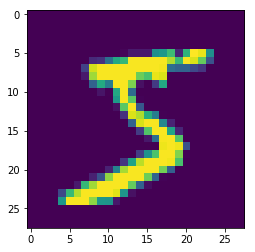

In [351]:
import matplotlib.pyplot as plt

image = train_data[0]
plt.imshow(image)
plt.show()

In [43]:
f = gzip.open('t10k-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 10000

f.read(16)

buf = f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8)
print('test_data type:',type(test_data))
print('test_data shape:',test_data.shape)

test_data = test_data.reshape(num_images, image_size, image_size)
print('test_data shape:',test_data.shape)
print('first test image shape:',test_data[0].shape)

test_data type: <class 'numpy.ndarray'>
test_data shape: (7840000,)
test_data shape: (10000, 28, 28)
first test image shape: (28, 28)


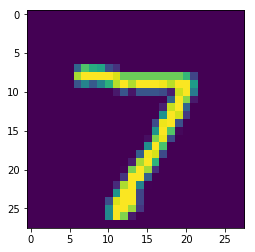

In [44]:
image = test_data[0]
plt.imshow(image)
plt.show()

## 2.2 Importing the Labels

In [89]:
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read(60000)
train_labels = np.frombuffer(buf, dtype=np.uint8)
print('train_labels shape:',train_labels.shape)
# Should print a 5
print('first training image label:',train_labels[0])

train_labels shape: (60000,)
first training image label: 5


In [90]:
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read(10000)
test_labels = np.frombuffer(buf, dtype=np.uint8)
print('test_labels shape:',test_labels.shape)
# Should print a 7
print('first test image label:',test_labels[0])

test_labels shape: (10000,)
first test image label: 7


## 2.3 Vectorize Data

In [116]:
def vectorize_data(data):
    return np.array([data[i].ravel() for i in range(len(data))]).transpose()

In [117]:
def vectorize_labels(labels,n):
    # n = largest number in labels, all labels assumed to be non-negative integers
    vlabels = []
    for i in range(len(labels)):
        label = labels[i]
        v = np.zeros((n,1))
        v[label] = 1
        vlabels.append(v)
    return np.array(vlabels).squeeze().transpose()

In [118]:
vdata = vectorize_data(train_data)
vdata.shape

(784, 60000)

In [119]:
vlabels = vectorize_labels(train_labels,10)
vlabels.shape

(10, 60000)

In [120]:
# Should have 1 in position 5
vlabels[:,0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

# 3. Training/ Testing the Network

I found two hidden layers with 69 nodes each seems to work quite well.

In [314]:
trainX = vectorize_data(train_data)
trainY = vectorize_labels(train_labels,10)

network = ANN([784,69,69,10])
network.train(trainX,trainY,10,0.01,1000000)

Training Complete!
Training took: 2402.285432100296 seconds


In [315]:
testX = vectorize_data(test_data)
testY = vectorize_labels(test_labels,10)

network.test(trainX,trainY)

Correctly labeled: 54527 out of 60000
Percent correct:


0.9087833333333334

In [317]:
network.test(testX,testY)

Correctly labeled: 9026 out of 10000
Percent correct:


0.9026

If we try to do better by descreasing eta and increasing the number of iterations, we improve significantly on the training set but less so on the test set. As a result I think the other hyperparameters are a better choice to avoid overfitting.

In [338]:
net2 = ANN([784,69,69,10])
net2.train(trainX,trainY,10,0.005,5*10**6)

Training Complete!
Training took: 11455.213525056839 seconds


In [339]:
net2.test(trainX,trainY)

Correctly labeled: 56492 out of 60000
Percent correct:


0.9415333333333333

In [347]:
net2.test(testX,testY)

Correctly labeled: 9162 out of 10000
Percent correct:


0.9162